In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import re

# Set the device
DEVICE = torch.device('cpu')
torch.autograd.set_detect_anomaly(True)

# Read the data
data = pd.read_csv('movie.csv')
#data = data[:250]
reviews = data['review']
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values



In [3]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

In [4]:
reviews = reviews.apply(preprocess_text)

In [5]:
def tokenize_text(text):
    return list(text)

In [6]:
reviews = reviews.apply(tokenize_text)

In [7]:
all_chars = string.printable
char_to_index = {ch: i for i, ch in enumerate(all_chars)}

In [8]:
char_to_index['<unk>'] = len(all_chars)

In [9]:
def sequence_to_tensor(seq):

    if len(seq) < 50:
        adding = 50-len(seq)
        tensor = torch.zeros(len(seq), dtype=torch.long)
        for i in range(len(seq)):
            char = seq[i]
            if char in char_to_index:
                tensor[i] = char_to_index[char]
            else:
                tensor[i] = char_to_index.get('<unk>', len(char_to_index))
        temp = torch.zeros(adding, dtype=torch.long)
        tensor = torch.cat((tensor,temp))
    else:
        tensor = torch.zeros(50, dtype=torch.long)
        for i in range(50):
            char = seq[i]
            if char in char_to_index:
                tensor[i] = char_to_index[char]
            else:
                tensor[i] = char_to_index.get('<unk>', len(char_to_index))
    return tensor




In [10]:
data = [sequence_to_tensor(seq) for seq in reviews]

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.4, random_state=42)
#valid_data, test_data, valid_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42)

In [12]:
train_data = train_data[0:300]
train_labels = train_labels[0:300]
test_data = test_data[0:120]
test_labels = test_labels[0:120]
#valid_data = valid_data[0:50]
#valid_labels = valid_labels[0:50]

In [50]:
class CharRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super().__init__()

        self.embedding = nn.Embedding(input_size, embedding_size)

        self.rnn = torch.nn.LSTM(embedding_size, hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, char, hidden_and_cell_state):
        embedded = self.embedding(char)

        output, hidden_and_cell_state = self.rnn(embedded, hidden_and_cell_state)
        output = self.dropout(hidden_and_cell_state[0][-1])
        output = output.squeeze(0)

        output = self.fc(output)

        return output,hidden_and_cell_state

    def init_zero_state(self):
        init_hidden = torch.zeros(1, hidden_size).to(DEVICE)
        init_cell = torch.zeros(1, hidden_size).to(DEVICE)
        return (init_hidden, init_cell)




In [51]:
input_size = len(all_chars)
hidden_size = 100
output_size = 2
batch_size = 1
learning_rate = 0.001
embedding_size = 100
NUM_EPOCHS = 25


In [52]:
model1 = CharRNN(input_size,embedding_size, hidden_size, output_size)
model1 = model1.to(DEVICE)
model1


CharRNN(
  (embedding): Embedding(100, 100)
  (rnn): LSTM(100, 100)
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [53]:
model2 = CharRNN(input_size,embedding_size, hidden_size, output_size)
model2 = model2.to(DEVICE)

In [54]:

optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

In [55]:
optimizer2 = optim.SGD(model2.parameters(), lr=learning_rate)

In [56]:
def compute_accuracy(model, review, label, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i in range(len(review)):
            count_pos,count_neg = 0,0
            hidden_and_cell_state = model.init_zero_state()
            rev = review[i]
            lab = label[i]
            lab = torch.tensor(lab,dtype=torch.long)
            rev = inputs.to(DEVICE)
            lab = labels.to(DEVICE)
            for c in range(50):
                outputs, hidden_and_cell_state = model(rev[c].view(1), hidden_and_cell_state)
                outputs = outputs.unsqueeze(0)
                predicted_prob = torch.softmax(outputs, dim=1)
                predicted_label_index = torch.argmax(predicted_prob)
                correct_pred += (predicted_label_index== lab).sum()
                num_examples += 1

    return correct_pred/num_examples * 100

Epoch: 001/025 | Batch 000/300 | Loss: 35.8023
Epoch: 001/025 | Batch 100/300 | Loss: 33.3639
Epoch: 001/025 | Batch 200/300 | Loss: 39.0733
training accuracy: 67.82%
Epoch: 002/025 | Batch 000/300 | Loss: 36.9355
Epoch: 002/025 | Batch 100/300 | Loss: 33.5392
Epoch: 002/025 | Batch 200/300 | Loss: 38.2250
training accuracy: 84.82%
Epoch: 003/025 | Batch 000/300 | Loss: 37.2877
Epoch: 003/025 | Batch 100/300 | Loss: 33.2200
Epoch: 003/025 | Batch 200/300 | Loss: 37.3975
training accuracy: 85.59%
Epoch: 004/025 | Batch 000/300 | Loss: 37.4056
Epoch: 004/025 | Batch 100/300 | Loss: 33.0784
Epoch: 004/025 | Batch 200/300 | Loss: 37.9516
training accuracy: 82.66%
Epoch: 005/025 | Batch 000/300 | Loss: 36.9892
Epoch: 005/025 | Batch 100/300 | Loss: 33.1215
Epoch: 005/025 | Batch 200/300 | Loss: 38.0708
training accuracy: 79.03%
Epoch: 006/025 | Batch 000/300 | Loss: 37.0350
Epoch: 006/025 | Batch 100/300 | Loss: 32.3315
Epoch: 006/025 | Batch 200/300 | Loss: 38.1353
training accuracy: 73.60

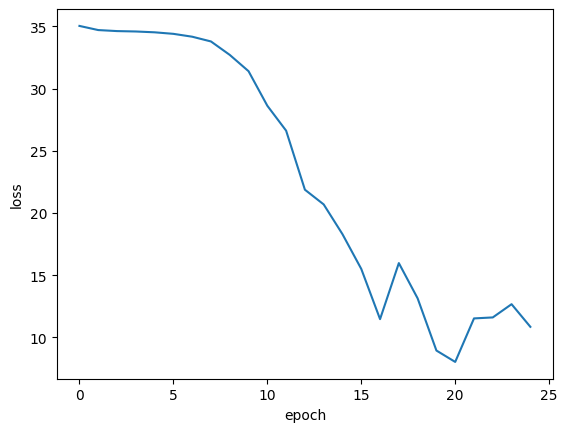

In [57]:
all_loss = []
for epoch in range(NUM_EPOCHS):
    losssum = 0
    model1.train()
    for i in range(len(train_data)):

        hidden_and_cell_state = model1.init_zero_state()
        loss = 0
        inputs = train_data[i]
        labels = train_labels[i]
        labels = torch.tensor(labels,dtype=torch.long)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer1.zero_grad()

        for c in range(50):

            outputs, hidden_and_cell_state = model1(inputs[c].view(1), hidden_and_cell_state)
            loss +=  F.cross_entropy(outputs, labels)

        loss.backward()
        optimizer1.step()
        losssum += loss
        ### LOGGING
        if not i % 100:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {i:03d}/{len(train_data):03d} | '
                   f'Loss: {loss:.4f}')
    all_loss.append(losssum.item() / len(train_data))
    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_accuracy(model1, train_data,train_labels, DEVICE):.2f}%')

    #print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

#print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

print(f'Test accuracy: {compute_accuracy(model1, test_data,test_labels, DEVICE):.2f}%')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(all_loss)
plt.show()

In [21]:
# all_loss = []
# for epoch in range(NUM_EPOCHS):

#     losssum = 0
#     model2.train()
#     for i in range(len(train_data)):
#         hidden_and_cell_state = model2.init_zero_state()
#         loss = 0
#         inputs = train_data[i]
#         labels = train_labels[i]
#         labels = torch.tensor(labels,dtype=torch.long)
#         inputs = inputs.to(DEVICE)
#         labels = labels.to(DEVICE)

#         optimizer2.zero_grad()

#         for c in range(50):

#             outputs, hidden_and_cell_state = model2(inputs[c].view(1), hidden_and_cell_state)
#             loss +=  F.cross_entropy(outputs, labels)
#         loss = loss/50
#         losssum += loss


#         loss.backward()
#         optimizer2.step()

#         ### LOGGING
#         if not i % 100:
#             print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
#                    f'Batch {i:03d}/{len(train_data):03d} | '
#                    f'Loss: {loss:.4f}')
#     all_loss.append(losssum / len(train_data))
#     with torch.set_grad_enabled(False):
#         print(f'training accuracy: '
#               f'{compute_accuracy(model2, train_data,train_labels, DEVICE):.2f}%')

#     #print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

# #print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

# print(f'Test accuracy: {compute_accuracy(model2, test_data,test_labels, DEVICE):.2f}%')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.plot(all_loss)
# plt.show()

In [22]:
def evaluate(model, seqs, predict_len=50):
    model.eval()
    hidden_and_cell_state = model.init_zero_state()
    input = preprocess_text(seqs)
    input =  tokenize_text(input)
    input = sequence_to_tensor(seqs)
    input = input.to(DEVICE)

    for p in range(len(input)):

        # Sample from the network as a multinomial distribution
        outputs, hidden_and_cell_state = model(input[p].view(1), hidden_and_cell_state)
        outputs = outputs.unsqueeze(0)

        predicted_prob = torch.softmax(outputs, dim=1)
        predicted_label_index = torch.argmax(predicted_prob)


    if(predicted_label_index == 0 ):
      return "this is a negative review"
    else:
      return "this is a positive review"


In [23]:
modle = model1
seqs = ['I hate this movie','trash','extremely awesome! everybody should see this movie','so damn fun, my kids loved it','too much sex scene for no reason. do not bring your parents.','John Wick brought out the pure form of me, i want to fight like him ']

for i in range(len(seqs)):
  print("***Movie Review:", seqs[i],  "***Evaluation: ",evaluate(modle, seqs[i], predict_len=50))

***Movie Review: I hate this movie ***Evaluation:  this is a positive review
***Movie Review: trash ***Evaluation:  this is a negative review
***Movie Review: extremely awesome! everybody should see this movie ***Evaluation:  this is a negative review
***Movie Review: so damn fun, my kids loved it ***Evaluation:  this is a negative review
***Movie Review: too much sex scene for no reason. do not bring your parents. ***Evaluation:  this is a negative review
***Movie Review: John Wick brought out the pure form of me, i want to fight like him  ***Evaluation:  this is a negative review


In [24]:
modle = model1
seqs = ['I beleive I waisted plenty of time just by watching this meaningful less movie.']

for i in range(len(seqs)):
  print("***Movie Review:", seqs[i],  "***Evaluation: ",evaluate(modle, seqs[i], predict_len=50))

***Movie Review: I beleive I waisted plenty of time just by watching this meaningful less movie. ***Evaluation:  this is a negative review


In [25]:
# modle = model2
# seqs = ['I hate this movie','trash','extremely awesome! everybody should see this movie','so damn fun, my kids loved it','too much sex scene for no reason. do not bring your parents.','John Wick brought out the pure form of me, i want to fight like him ']
# for i in seqs:
#   evaluate(modle, seqs[i], predict_len=50)